## IB三均线交易+金字塔仓位下单控制模型实盘交易策略


### 1 策略运行设置

#### 1.1 登录 Workstation

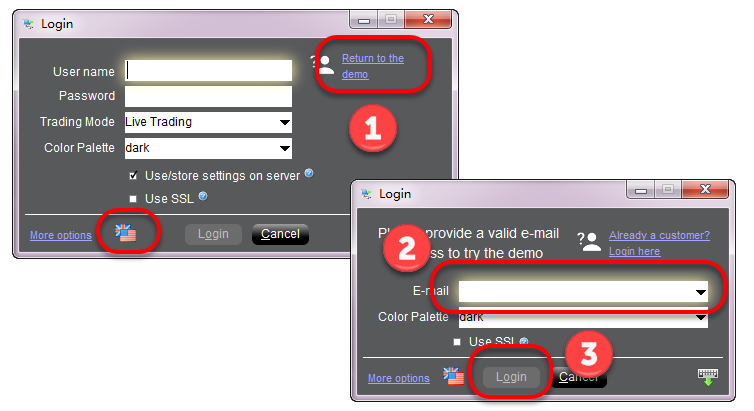

#### 1.2 Workstation 设置

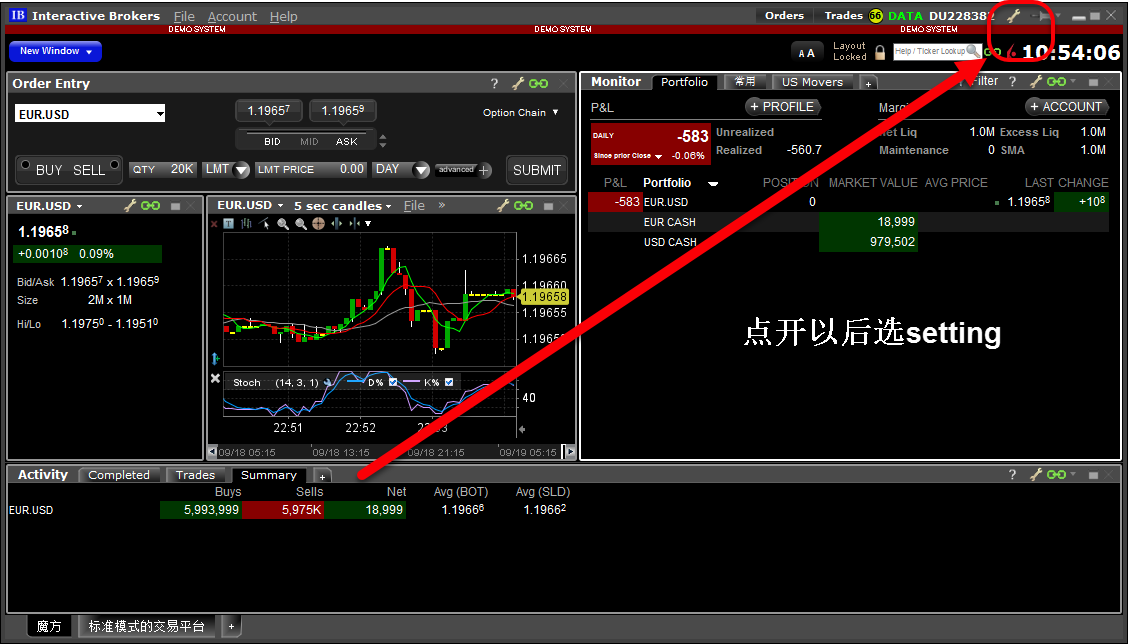

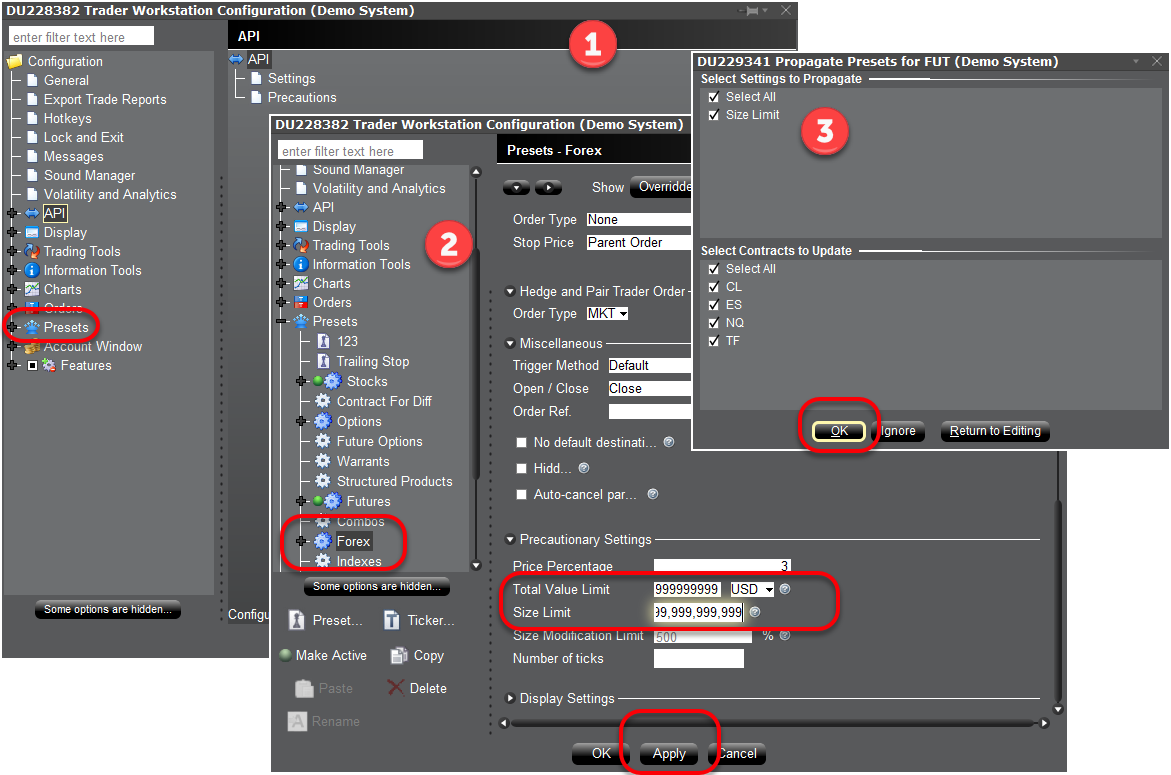

### 2 策略代码

**注意：如果发生一些未知错误，则将python重启即可；**

In [1]:
from datetime import datetime, timedelta
import threading
import math

from ibapi import wrapper
from ibapi.client import EClient
from ibapi.order import Order
from ibapi.order_state import OrderState
from ibapi.common import *
from ibapi.contract import *
from ibapi.ticktype import *

import pandas as pd
import numpy as np
import talib

#### 2.1 定义响应函数（Wrapper）

In [2]:
class Trader_general(wrapper.EWrapper, EClient):
    def __init__(self):
        wrapper.EWrapper.__init__(self)
        EClient.__init__(self, wrapper=self)

        self.account = None                         # 记录账户名称
        self.reqID = None                           # 记录请求ID
        self.position_value = 0                     # 记录持仓市值；对应服务器返回的marketValue
        self.net_liquidation = 0                    # 记录账户总净值，对应服务器返回的NetLiquidation
        self.leverage = 0                           # 记录持仓比例，超过50%以上就不再开新仓；
        self.acc_position = 0                       # 用于记录当前持仓数量及方向，实现仓位控制功能，对应服务器返回的position；
        self.control = threading.Event()            # 实现线程控制


        # connect to the IB TWS
        print('Connecting ...')
        self.connect("127.0.0.1", 7497, clientId=66)
        
        # 在初始化函数中自动启动run函数，相当于实例化之后就自动启动线程运行了，不用手动启动；
        # 函数作为参数都无需加括号，加括号就变成调用了；
        self.thread = threading.Thread(target=self.run)    
        self.thread.start()

        # Request frozen market data in case live is not available.
        # Different market data subscriptions give you access to different information
        # https://interactivebrokers.github.io/tws-api/market_data_type.html#gsc.tab=0
        self.reqMarketDataType(4)

    def increment_id(self):
        self.reqID += 1

    # override EWrapper method
    def nextValidId(self, orderId: int):
        """ Receives next valid order id. Catch valid ID after connection"""
        self.reqID =  orderId
        # 释放线程锁，即将Flag设置为True，只有在拿到请求ID之后才能继续，因为IB程序中很多请求都需要ID作为参数；
        # 这里的wait在启动函数start中，启动函数中要开始调用实时Bar数据，需要用到reqID,必须拿到ID之后才能调数据；
        self.control.set()        

    # override EWrapper method
    def connectAck(self):
        """ callback signifying completion of successful connection """
        print('Connected.')
        
    # override EWrapper method
    def managedAccounts(self, accountsList: str):
        """Receives a comma-separated string with the managed account ids.
            reqManagedAccts() can only be made when connected to a FA managed account"""
        self.account =  accountsList.split(',')[0]  # Get the first item of the comma-delimited list
    
    
    # override EWrapper method，placeOrder之后会自动触发openOrder；
    # 下单成交之后要触发reqPositions和reqAccountUpdates获得最新的持仓情况和账户净值信息；
    def openOrder(self, orderId: OrderId, contract: Contract, order: Order,
                  orderState: OrderState):
        if orderState.status == 'Filled':
            print(
                'OrderId: {},\ncontract: {},\norder_direction: {},\norder_type: {},\nlmt_price/stp_price: {}/{},\norder_state:{} '
                .format(orderId, contract.symbol, order.action, order.orderType, order.lmtPrice, order.auxPrice,
                        orderState.status))
            
            # 线程上锁，将Flag设置成False，等待读取到acc_position信息后解锁；
            # 注意，clear只是亮起红灯，后续代码会继续执行，策略会在wait()的地方阻塞；
            self.control.clear()                                 # 将Flag设置为False；
            self.reqPositions()                                  # 更新 self.acc_position 信息
            self.reqAccountUpdates(True, self.account)           # 更新账户净值信息

    def updateAccountValue(self, key:str, val:str, currency:str,
                            accountName:str):
        """ This function is called only when ReqAccountUpdates on
        EEClientSocket object has been called. """
        # valid keys 参考信息：http://interactivebrokers.github.io/tws-api/account_updates.html#acct_update_request
        # Account key 参考信息：
        # https://institutions.interactivebrokers.com/en/software/tws/usersguidebook/realtimeactivitymonitoring/the_account_window.html
        if key == 'NetLiquidation-S':
            print('{}: {}'.format(key, val))
            self.net_liquidation = float(val)
            self.control.set()

    def updatePortfolio(self, contract:Contract, position:float,
                        marketPrice:float, marketValue:float,
                        averageCost:float, unrealizedPNL:float,
                        realizedPNL:float, accountName:str):
        print('Market value: %s' % marketValue)          # marketValue是以本币为计量单位的；
        self.position_value = abs(float(marketValue))
        self.leverage = self.position_value / self.net_liquidation
        print('Leverage: %f' % self.leverage)

    # override EWrapper method
    def position(self, account:str, contract:Contract, position:float,
                 avgCost:float):
        self.acc_position = position
        self.control.set()
        print('\nCurrent position: %d\n' % self.acc_position)
        

    def exit(self):
        self.done = True


In [3]:
# general主要定义了一般的回调函数的行为，trader继承了一般行为，同时定义了自己要求的特定行为，比如交易的逻辑；
# 理论上可以写另一个trader用另一种策略，但是general的内容基本不用变，便于后期策略拓展；
class Trader(Trader_general):
    def __init__(self, symbol):
        super().__init__()
        self.data = []                                   # 存储 bar 数据信息，
        self.max_data = 21                               # data序列允许的最大长度，避免内存占用持续增加
        # self.order_contract = self.fx_contract(symbol)
        self.contract = self.fx_contract(symbol)
        # self.contract = self.stock_contract('AAPL')
        
        self.max_leverage = 0.5                          # 限制持仓比例
        self.trading_unit = 200000                       # 初始交易单位
        self.add_on_count = 0                            # 加仓次数计数
        
        self.reqAccountUpdates(True, self.account)
        self.control.wait()
        if self.net_liquidation:                         # 如果登陆后账户有原始仓位
            self.leverage = self.position_value/self.net_liquidation                # 更新当前持仓比例

    # 定义股票合约
    def stock_contract(self, symbol: str):
        """
        定义查询合约属性，服务器根据属性匹配合约返回数据，如果对应到一个以上的合约会报错
        :param symbol: 比如 ’EUR', 'APPL'
        :param secType: 证券类型，股票：‘STK', 外汇：’CASH', 商品：‘CMDTY', 指数：’IND'...
        :return: 返回定义好的合约
        """
        contract = Contract()
        contract.symbol = symbol  # 交易品种
        contract.secType = 'STK'
        contract.currency = "USD"
        contract.exchange = 'ISLAND'  # 交易所
        return contract
        # 更多合约类型可以参考api安装路径下 ...IB_API\samples\Python\Testbed\ContractSamples.py
        
        # 定义外汇合约
    def fx_contract(self, symbol: str):
        """create fx_contract"""
        contract = Contract()
        contract.symbol = symbol
        contract.secType = 'CASH'
        contract.currency = "USD"
        contract.exchange = 'IDEALPRO'
        return contract

    def create_mkt_order(self, action: str, quantity):
        """ Creates a market order."""
        order = Order()
        order.action = action       # 'BUY' or 'SELL'
        order.totalQuantity = quantity
        order.account = self.account
        order.orderType = 'MKT'
        order.orderId = self.reqID
        self.reqID += 1
        return order

    def get_df(self):
        # self.data 列表转化为DataFrame, 从服务器拿到的数据都存储在self.data中；
        index = [i for i in range(len(self.data))]         #列表解析；
        
        # 注意：将列表转换成为DataFrame时必须要提供索引；
        return pd.DataFrame(self.data, index, columns=['date','open','high','low','close']).set_index('date')

    def calc_signal(self, df):
        # 根据bar数据计算开平仓信号
        
        # 计算均线
        df['MA5'] = talib.MA(df.close.values, 5)
        df['MA10'] = talib.MA(df.close.values, 10)
        df['MA20'] = talib.MA(df.close.values, 20)
        
        # 5均线和10均线同时位于20均线上方准备开多仓，同时位于20均线下准备开空仓
        df.loc[((df.MA5 > df.MA20) & (df.MA10 >= df.MA20)), 'direction'] = 1
        df.loc[((df.MA5 < df.MA20) & (df.MA10 <= df.MA20)), 'direction'] = -1
        
        # 不满足以上条件定义为方向不明朗，不开仓
        df['direction'].fillna(0, inplace=True)                
        
        # 计算5均线和10均线的交叉
        # ma_diff 有两种取值：+1，-1 （0的情况很少，基本可以忽略）
        # cross 有三种取值： +1，-1, 0
        df['ma_diff'] = np.sign(df.MA5 - df.MA10)  
        df['cross'] = np.sign(df.ma_diff - df.ma_diff.shift(1))  
        
        # 有多仓条件且产生金叉时发出多头信号（signal==2），有空仓条件且产生死叉使发出空头信号（signal==-2)
        # signal 有五种取值：+2，+1，0，-1，-2
        df['signal'] =df.cross + df.direction  
        
        # 返回最后行数据，实时交易仅根据最近产生的信号进行操作
        return df.iloc[-1]   

    def check_signal(self):
        # 先转换成为DataFrame，将self.data变成DataFrame，然后计算信号，并将最后一行计算结果返回；
        
        df = self.get_df()
        return self.calc_signal(df)

    def open_position(self, action: str):
        # 实现金字塔型加仓
        self.control.wait()                    # 确保 self.acc_position 更新完毕
        
        if self.acc_position != 0:
            self.add_on_count += 1
        
        # 计算下单数量
        quantity = self.trading_unit*math.pow(0.5,self.add_on_count)
        
        # 建仓时数量递减，如果加仓数量小于20000则不操作
        if quantity >= 20000:
            order = self.create_mkt_order(action, quantity)
            if action == 'BUY':
                print('\n     Open long:', '  %d' % self.reqID)
            elif action == 'SELL':
                print('\n     Open short:', '  %d' % self.reqID)
            self.placeOrder(self.reqID, self.contract, order)
            self.increment_id()
        else:
            print('Order too small.')

    def close_position(self):
        # 让策略平仓；
        order = None
        
        # 因为在openOrder中会更新持仓情况，需要拿到更新后的acc_position才能进行后续操作；
        self.control.wait()                # 确保 self.acc_position 更新完毕;
        
        if self.acc_position > 0:          # 当前持有多头仓位
            print('\n     Close long position.')
            order = self.create_mkt_order('SELL', abs(self.acc_position))
        
        elif self.acc_position < 0:        # 当前持有空仓
            print('\n     Close short position.')
            order = self.create_mkt_order('BUY', abs(self.acc_position))
        
        self.placeOrder(self.reqID, self.contract, order)
        self.add_on_count = 0
        self.increment_id()

    # 重写 wrapper 中的函数，实现自定义逻辑，策略的主逻辑；
    def realtimeBar(self, reqId: TickerId, time: int, open: float, high: float, low: float, close: float,
                    volume: int, wap: float, count: int):
        """ Updates the real time 5 seconds bars

        reqId - the request's identifier
        bar.time  - start of bar in unix (or 'epoch') time
        bar.endTime - for synthetic bars, the end time (requires TWS v964). Otherwise -1.
        bar.open  - the bar's open value
        bar.high  - the bar's high value
        bar.low   - the bar's low value
        bar.close - the bar's closing value
        bar.volume - the bar's traded volume if available
        bar.WAP   - the bar's Weighted Average Price
        bar.count - the number of trades during the bar's timespan (only available
            for TRADES)."""
        
        # 将从服务器返回的 bar 数据加入 self.data 数组
        self.data.append((datetime.fromtimestamp(time), open, high, low, close))
        
        # 记录数组长度
        n_bar = len(self.data)

        if n_bar > self.max_data:                             # 产生有效信号需要21个数据点，有足够多计算数据以后
            self.data = self.data[-1*self.max_data:]                 # 仅保留最后21个数据，防止内存占用一直增加
            signal_series = self.check_signal()                      # 使用direction，cross和signal字段
            print(signal_series.name,'   ', signal_series.tolist())  # 打印行情及信号
            
            # 先判断是否满足平仓条件
            # if signal_series.cross*open_direction == -1 or signal_series.direction*open_direction == -1:
            # 如果多单进场后两天短周期均线同时到长周期均线下方，则原多单平仓，空单相反操作；
            # 策略的平仓逻辑；
            open_direction = np.sign(self.acc_position)              # 获得当前持仓方向
            if signal_series.direction * open_direction == -1:
                self.close_position()
            
            # 交易主逻辑
            if self.leverage < self.max_leverage:                    # 总仓位控制
                if signal_series.signal == 2:                        # 当出现多头信号开多仓
                    self.open_position('BUY')
                if signal_series.signal == -2:                       # 当出现空头信号时开空仓
                    self.open_position('SELL')
        else:
            print('Bar No.: %d' % n_bar)

    def start(self):
        self.control.wait()                                # 暂停，观察线程锁状态，下一个request需要reqID；
        self.reqRealTimeBars(self.reqID, self.contract, 5, 'MIDPOINT', True, [])
        self.increment_id()

In [4]:
ma_trader = Trader('EUR')
ma_trader.start()

Connecting ...


ERROR:root:ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfuture


Connected.


ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:hkhmds


NetLiquidation-S: 1003235.15
Bar No.: 1
Bar No.: 2
Bar No.: 3
Bar No.: 4
Bar No.: 5
Bar No.: 6
Bar No.: 7
Bar No.: 8
Bar No.: 9
Bar No.: 10
Bar No.: 11
Bar No.: 12
Bar No.: 13
Bar No.: 14
Bar No.: 15
Bar No.: 16
Bar No.: 17
Bar No.: 18
Bar No.: 19
Bar No.: 20
Bar No.: 21


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: RuntimeWarning: invalid value encountered in sign
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:84: RuntimeWarning: invalid value encountered in sign


2017-09-27 17:46:25     [1.17368, 1.173725, 1.173675, 1.173725, 1.17368, 1.1736680000000002, 1.1736520000000001, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:46:30     [1.173725, 1.173765, 1.173725, 1.173765, 1.173702, 1.1736775000000002, 1.17365225, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:46:35     [1.173765, 1.173765, 1.17376, 1.17376, 1.17372, 1.1736865, 1.1736515000000003, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:46:40     [1.17376, 1.17376, 1.17374, 1.173755, 1.1737370000000003, 1.1736980000000001, 1.1736510000000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:46:45     [1.173755, 1.17385, 1.173755, 1.17385, 1.1737710000000006, 1.1737175, 1.1736645000000003, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:46:50     [1.17385, 1.17385, 1.17383, 1.17383, 1.1737920000000004, 1.1737360000000001, 1.173677, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:46:55     [1.17383, 1.17387, 1.17383, 1.173855, 1.1738100000000002, 1.173756, 1.1736940000000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:47:00     [1.173855, 1.17387, 1.173845, 1.173865, 1.173831000000

2017-09-27 17:50:30     [1.174135, 1.17415, 1.174125, 1.17415, 1.174102, 1.1740944999999996, 1.17408375, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:50:35     [1.17415, 1.174175, 1.174145, 1.17415, 1.174119, 1.1741039999999998, 1.1740880000000002, 1.0, 1.0, 0.0, 1.0]
NetLiquidation-S: 1003233.87
Market value: 410950.74
Leverage: 0.409626
2017-09-27 17:50:40     [1.17415, 1.17415, 1.17409, 1.17409, 1.174126, 1.1741014999999997, 1.1740892500000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:50:45     [1.17409, 1.174105, 1.174085, 1.174105, 1.174126, 1.1741065000000002, 1.17408975, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:50:50     [1.174105, 1.17411, 1.174065, 1.174065, 1.174112, 1.1741024999999998, 1.1740887500000001, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:50:55     [1.174065, 1.174065, 1.17403, 1.174035, 1.174089, 1.1740955000000004, 1.1740865000000003, 1.0, -1.0, -1.0, 0.0]
2017-09-27 17:51:00     [1.174035, 1.174045, 1.173995, 1.174035, 1.174066, 1.1740925000000002, 1.1740855000000003, 0.0, -1.0, 0.0, 0.0]
2017-09

2017-09-27 17:55:10     [1.174385, 1.17442, 1.174265, 1.174335, 1.1743590000000004, 1.1743765, 1.1743167499999998, 1.0, -1.0, -1.0, 0.0]
2017-09-27 17:55:15     [1.174335, 1.174425, 1.174285, 1.174405, 1.1743730000000003, 1.174379, 1.1743267499999999, 1.0, -1.0, 0.0, 1.0]
2017-09-27 17:55:20     [1.174405, 1.174445, 1.174385, 1.174405, 1.1743830000000002, 1.174382, 1.1743357499999998, 1.0, 1.0, 1.0, 2.0]
Order too small.
2017-09-27 17:55:25     [1.174405, 1.174435, 1.174395, 1.174425, 1.1743910000000004, 1.1743860000000002, 1.1743467499999998, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:55:30     [1.174425, 1.174435, 1.174415, 1.17442, 1.174398, 1.1743875000000001, 1.1743554999999999, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:55:35     [1.17442, 1.17446, 1.174415, 1.17446, 1.174423, 1.1743910000000002, 1.1743644999999998, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:55:40     [1.17446, 1.17446, 1.174425, 1.174435, 1.1744290000000004, 1.1744010000000007, 1.1743717500000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:55:45  

ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm
ERROR:root:ERROR -1 2108 Market data farm connection is inactive but should be available upon demand.cashfarm


2017-09-27 17:58:00     [1.174835, 1.174875, 1.174765, 1.174875, 1.1748610000000002, 1.174839, 1.1747580000000002, 1.0, 1.0, 0.0, 1.0]


ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm


2017-09-27 17:58:05     [1.174875, 1.17495, 1.174865, 1.174905, 1.174868, 1.1748565, 1.17477, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:58:10     [1.174905, 1.174915, 1.17486, 1.17491, 1.174877, 1.174866, 1.17478225, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:58:15     [1.17491, 1.174925, 1.174885, 1.174925, 1.17489, 1.1748764999999999, 1.17479575, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:58:20     [1.174925, 1.174925, 1.17488, 1.17489, 1.1749009999999998, 1.1748819999999998, 1.174801, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:58:25     [1.17489, 1.17491, 1.17488, 1.174905, 1.1749069999999997, 1.174884, 1.1748105000000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:58:30     [1.174905, 1.174905, 1.174865, 1.174865, 1.174899, 1.1748835, 1.1748250000000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:58:35     [1.174865, 1.174885, 1.174865, 1.174865, 1.17489, 1.1748835, 1.1748345, 1.0, 1.0, 0.0, 1.0]
2017-09-27 17:58:40     [1.174865, 1.174865, 1.174865, 1.174865, 1.174878, 1.174884, 1.1748437500000002, 1.0, -1.0, -1.0, 0.0]
2017-09-27 1

2017-09-27 18:02:55     [1.17514, 1.175165, 1.175075, 1.17513, 1.1751110000000002, 1.1750635000000003, 1.1750962499999997, 0.0, 1.0, 0.0, 0.0]
2017-09-27 18:03:00     [1.17513, 1.17515, 1.17512, 1.17514, 1.1751359999999997, 1.1750765000000003, 1.1750919999999998, 0.0, 1.0, 0.0, 0.0]
2017-09-27 18:03:05     [1.17514, 1.175165, 1.175075, 1.175125, 1.1751340000000003, 1.1750900000000004, 1.175085, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:03:10     [1.175125, 1.175255, 1.175115, 1.17525, 1.1751570000000002, 1.1751120000000004, 1.1750865, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:03:15     [1.17525, 1.17525, 1.175235, 1.175245, 1.175178, 1.175137, 1.1750909999999997, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:03:20     [1.175245, 1.175255, 1.175225, 1.17525, 1.1752020000000003, 1.1751565000000002, 1.1750957499999997, 1.0, 1.0, 0.0, 1.0]

Current position: 0

2017-09-27 18:03:25     [1.17525, 1.17528, 1.175225, 1.17528, 1.1752300000000004, 1.1751830000000005, 1.1751055, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:03:30     [

ERROR:root:ERROR -1 1100 Connectivity between IB and Trader Workstation has been lost.
ERROR:root:ERROR -1 2103 Market data farm connection is broken:hfarm
ERROR:root:ERROR -1 2103 Market data farm connection is broken:secdefhk
ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:hkhmds
ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:cashhmds
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfarm
ERROR:root:ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR:root:ERROR -1 1102 Connectivity between IB and Trader Workstation has been restored - data maintained.


NetLiquidation-S: 1003501.29
Market value: 0.0
Leverage: 0.000000


ERROR:root:ERROR -1 2104 Market data farm connection is OK:secdefhk
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:hkhmds
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:cashhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:cashhmds


2017-09-27 18:04:35     [1.175275, 1.175285, 1.175275, 1.175285, 1.175278, 1.1753025, 1.17527625, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:04:40     [1.175285, 1.17537, 1.175275, 1.175365, 1.1752880000000003, 1.1753084999999999, 1.1752875, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:04:45     [1.175365, 1.175375, 1.175345, 1.175345, 1.175305, 1.1753144999999994, 1.1752984999999998, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:04:50     [1.175345, 1.175355, 1.175345, 1.175355, 1.175325, 1.1753159999999998, 1.17530375, 1.0, 1.0, 1.0, 2.0]

     Open long:   300
2017-09-27 18:04:55     [1.175355, 1.175355, 1.175295, 1.17531, 1.1753319999999998, 1.1753129999999994, 1.1753069999999997, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:05:00     [1.17531, 1.17531, 1.175265, 1.175265, 1.175328, 1.1753029999999998, 1.17530775, 0.0, 1.0, 0.0, 0.0]
2017-09-27 18:05:05     [1.175265, 1.175265, 1.175235, 1.17525, 1.1753050000000003, 1.1752964999999997, 1.1753062499999998, -1.0, 1.0, 0.0, -1.0]
2017-09-27 18:05:10     [1.17525, 1.175265, 

ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:hkhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:hkhmds
ERROR:root:ERROR -1 2103 Market data farm connection is broken:hfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR:root:ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfarm
ERROR:root:ERROR -1 2104 Market data farm connection is OK:usfarm



Leverage: 0.468481

Current position: -400000


Current position: -400000

2017-09-27 18:06:35     [1.175275, 1.175285, 1.175265, 1.175285, 1.1752610000000001, 1.1752560000000003, 1.1752575, 0.0, 1.0, 0.0, 0.0]

Current position: -400000


Current position: -400000


Current position: -400000

2017-09-27 18:06:40     [1.175285, 1.17529, 1.175285, 1.17529, 1.175274, 1.17526, 1.17525875, 1.0, 1.0, 0.0, 1.0]

     Close short position.
NetLiquidation-S: 1003482.51

Current position: -400000

Market value: -470103.98
Leverage: 0.468473

Current position: -400000


Current position: 0

OrderId: 308,
contract: EUR,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 1.1753/0.0,
order_state:Filled 
2017-09-27 18:06:45     [1.17529, 1.17529, 1.17526, 1.175265, 1.1752759999999998, 1.175261, 1.1752595000000001, 1.0, 1.0, 0.0, 1.0]

Current position: 0

OrderId: 308,
contract: EUR,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 1.1753/0.0,
order_state:Filled 
OrderId: 308,
c

ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:cashhmds
ERROR:root:ERROR -1 2106 HMDS data farm connection is OK:cashhmds


2017-09-27 18:06:55     [1.1753, 1.1753, 1.175285, 1.175295, 1.175289, 1.1752749999999998, 1.1752652499999996, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:07:00     [1.175295, 1.175355, 1.17529, 1.175355, 1.1753019999999998, 1.1752879999999999, 1.1752699999999996, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:07:05     [1.175355, 1.175355, 1.175345, 1.175345, 1.175318, 1.175297, 1.1752744999999998, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:07:10     [1.175345, 1.17539, 1.175345, 1.17539, 1.1753360000000002, 1.1753095, 1.1752822499999998, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:07:15     [1.17539, 1.17539, 1.175235, 1.17528, 1.175333, 1.17531, 1.17528175, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:07:20     [1.17528, 1.17528, 1.17516, 1.17516, 1.175306, 1.1752974999999999, 1.1752767499999996, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:07:25     [1.17516, 1.17517, 1.17516, 1.17517, 1.1752690000000001, 1.1752855000000002, 1.1752727500000002, 0.0, -1.0, -1.0, -1.0]
2017-09-27 18:07:30     [1.17517, 1.17517, 1.17513, 1.17516, 1.175232, 1.17527

2017-09-27 18:12:10     [1.175195, 1.175195, 1.175195, 1.175195, 1.1751930000000002, 1.1752045, 1.1751712499999996, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:12:15     [1.175195, 1.175195, 1.175165, 1.17517, 1.1751900000000002, 1.1751975, 1.1751774999999998, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:12:20     [1.17517, 1.175195, 1.175165, 1.175165, 1.1751840000000002, 1.1751915, 1.1751807499999996, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:12:25     [1.175165, 1.175165, 1.175165, 1.175165, 1.175178, 1.1751855, 1.1751829999999999, 0.0, -1.0, 0.0, 0.0]
2017-09-27 18:12:30     [1.175165, 1.175165, 1.175165, 1.175165, 1.1751719999999999, 1.175182, 1.1751852499999997, -1.0, -1.0, 0.0, -1.0]
2017-09-27 18:12:35     [1.175165, 1.175165, 1.175165, 1.175165, 1.1751659999999997, 1.1751795, 1.1751875, -1.0, -1.0, 0.0, -1.0]
2017-09-27 18:12:40     [1.175165, 1.175165, 1.17507, 1.17507, 1.1751459999999998, 1.1751679999999998, 1.175183, -1.0, -1.0, 0.0, -1.0]
2017-09-27 18:12:45     [1.17507, 1.17507, 1.17507, 1.17507,


Current position: -200000

OrderId: 310,
contract: EUR,
order_direction: SELL,
order_type: MKT,
lmt_price/stp_price: 1.1749/0.0,
order_state:Filled 
OrderId: 310,
contract: EUR,
order_direction: SELL,
order_type: MKT,
lmt_price/stp_price: 1.1749/0.0,
order_state:Filled 
NetLiquidation-S: 1003456.40
Market value: -234983.99
Leverage: 0.234175

Current position: -200000


Current position: -200000

2017-09-27 18:17:15     [1.17491, 1.17491, 1.17491, 1.17491, 1.1748939999999997, 1.1749050000000003, 1.1749390000000004, -1.0, -1.0, 0.0, -1.0]
2017-09-27 18:17:20     [1.17491, 1.17491, 1.17487, 1.17488, 1.1748929999999995, 1.1749030000000003, 1.174932, -1.0, -1.0, 0.0, -1.0]
2017-09-27 18:17:25     [1.17488, 1.174885, 1.174875, 1.174875, 1.1748949999999998, 1.1749005000000003, 1.17492625, -1.0, -1.0, 0.0, -1.0]
NetLiquidation-S: 1003471.39
Market value: -234971.0
Leverage: 0.234158
2017-09-27 18:17:30     [1.174875, 1.174885, 1.174785, 1.174785, 1.1748719999999997, 1.1748890000000007, 1.174

2017-09-27 18:20:25     [1.175235, 1.17524, 1.175235, 1.175235, 1.1752140000000002, 1.1751735, 1.17509725, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:20:30     [1.175235, 1.17524, 1.175235, 1.175235, 1.1752280000000002, 1.1751975000000001, 1.17510425, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:20:35     [1.175235, 1.17526, 1.17523, 1.175255, 1.175235, 1.1752165, 1.1751122500000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:20:40     [1.175255, 1.175285, 1.175255, 1.17528, 1.175248, 1.1752280000000002, 1.175124, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:20:45     [1.17528, 1.17533, 1.17526, 1.175315, 1.175264, 1.1752385000000003, 1.1751412500000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:20:50     [1.175315, 1.175375, 1.175295, 1.175355, 1.175288, 1.175251, 1.1751592500000003, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:20:55     [1.175355, 1.175375, 1.175325, 1.175355, 1.1753120000000001, 1.1752700000000005, 1.175175, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:21:00     [1.175355, 1.17537, 1.175325, 1.175325, 1.175326, 1.1752805000000006, 1.1

2017-09-27 18:24:05     [1.175485, 1.17549, 1.175435, 1.17544, 1.1755520000000002, 1.1755049999999998, 1.1754492499999998, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:24:10     [1.17544, 1.1755, 1.17543, 1.175495, 1.175542, 1.1755095, 1.17545175, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:24:15     [1.175495, 1.17554, 1.175495, 1.17552, 1.175507, 1.1755169999999997, 1.1754609999999999, 1.0, -1.0, -1.0, 0.0]
2017-09-27 18:24:20     [1.17552, 1.175535, 1.175515, 1.175515, 1.175491, 1.175525, 1.1754697500000002, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:24:25     [1.175515, 1.175535, 1.175515, 1.175515, 1.175497, 1.1755290000000003, 1.1754785000000003, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:24:30     [1.175515, 1.175535, 1.175495, 1.175505, 1.17551, 1.175531, 1.1754865, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:24:35     [1.175505, 1.17551, 1.175375, 1.1754, 1.1754909999999996, 1.1755165, 1.17548925, 1.0, -1.0, 0.0, 1.0]
2017-09-27 18:24:40     [1.1754, 1.175415, 1.175375, 1.17541, 1.1754689999999999, 1.175488, 1.17548825000

OrderId: 338,
contract: EUR,
order_direction: BUY,
order_type: MKT,
lmt_price/stp_price: 1.1755/0.0,
order_state:Filled 

Current position: 0

NetLiquidation-S: 1003228.27
Market value: 0.0
Leverage: 0.000000

Current position: 0

2017-09-27 18:28:05     [1.175485, 1.17549, 1.17546, 1.175465, 1.175418, 1.1753455000000002, 1.1753172500000002, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:28:10     [1.175465, 1.175465, 1.175385, 1.17539, 1.1754309999999997, 1.1753620000000002, 1.1753209999999998, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:28:15     [1.17539, 1.17539, 1.17536, 1.175375, 1.175437, 1.1753740000000004, 1.17532375, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:28:20     [1.175375, 1.175385, 1.17537, 1.175385, 1.1754200000000001, 1.1753870000000004, 1.1753267499999995, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:28:25     [1.175385, 1.17541, 1.175385, 1.175405, 1.1754039999999997, 1.1753960000000006, 1.1753309999999997, 1.0, 1.0, 0.0, 1.0]

Current position: 0

2017-09-27 18:28:30     [1.175405, 1.17541, 1.175395, 1.17

2017-09-27 18:32:40     [1.175185, 1.175225, 1.17518, 1.175215, 1.1751829999999996, 1.1751755, 1.17515675, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:32:45     [1.175215, 1.175275, 1.175215, 1.17526, 1.1752019999999996, 1.1751844999999999, 1.1751639999999999, 1.0, 1.0, 0.0, 1.0]
NetLiquidation-S: 1003241.57
Market value: 235053.99
Leverage: 0.234295
2017-09-27 18:32:50     [1.17526, 1.175275, 1.17526, 1.175275, 1.1752239999999996, 1.1751954999999998, 1.1751719999999999, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:32:55     [1.175275, 1.175275, 1.175255, 1.175255, 1.1752379999999998, 1.175204, 1.1751792499999998, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:33:00     [1.175255, 1.175255, 1.175245, 1.175255, 1.1752519999999997, 1.1752125, 1.17518675, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:33:05     [1.175255, 1.175275, 1.175255, 1.17526, 1.1752609999999997, 1.175222, 1.1751945000000001, 1.0, 1.0, 0.0, 1.0]
2017-09-27 18:33:10     [1.17526, 1.17526, 1.175235, 1.175235, 1.175256, 1.175229, 1.1751977500000002, 1.0, 1.0, 0.0,

2017-09-27 18:36:50     [1.175205, 1.175215, 1.175195, 1.1752, 1.1752190000000007, 1.1752414999999998, 1.1752220000000002, 0.0, -1.0, 0.0, 0.0]
2017-09-27 18:36:55     [1.1752, 1.175205, 1.1752, 1.175205, 1.1752150000000006, 1.1752365, 1.1752262500000004, 0.0, -1.0, 0.0, 0.0]
2017-09-27 18:37:00     [1.175205, 1.175205, 1.175195, 1.175205, 1.1752070000000006, 1.1752284999999998, 1.1752267500000007, 0.0, -1.0, 0.0, 0.0]
2017-09-27 18:37:05     [1.175205, 1.175215, 1.175205, 1.175205, 1.1752040000000004, 1.1752175, 1.1752275, -1.0, -1.0, 0.0, -1.0]
2017-09-27 18:37:10     [1.175205, 1.175215, 1.175075, 1.175075, 1.1751780000000003, 1.1751995, 1.1752187499999998, -1.0, -1.0, 0.0, -1.0]
2017-09-27 18:37:15     [1.175075, 1.17508, 1.175055, 1.175075, 1.1751530000000003, 1.1751859999999998, 1.1752124999999998, -1.0, -1.0, 0.0, -1.0]

Current position: 0

2017-09-27 18:37:20     [1.175075, 1.175135, 1.175065, 1.175105, 1.175133, 1.1751739999999997, 1.1752077499999996, -1.0, -1.0, 0.0, -1.0]
2

ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:hkhmds
ERROR:root:ERROR -1 2103 Market data farm connection is broken:hfarm
ERROR:root:ERROR -1 2103 Market data farm connection is broken:cashfarm
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfuture
ERROR:root:ERROR -1 2103 Market data farm connection is broken:usfarm
ERROR:root:ERROR -1 2105 HMDS data farm connection is broken:cashhmds
ERROR:root:ERROR -1 1100 Connectivity between IB and Trader Workstation has been lost.
ERROR:root:ERROR -1 2103 Market data farm connection is broken:secdefhk
ERROR:root:ERROR -1 1100 Connectivity between IB and Trader Workstation has been lost.


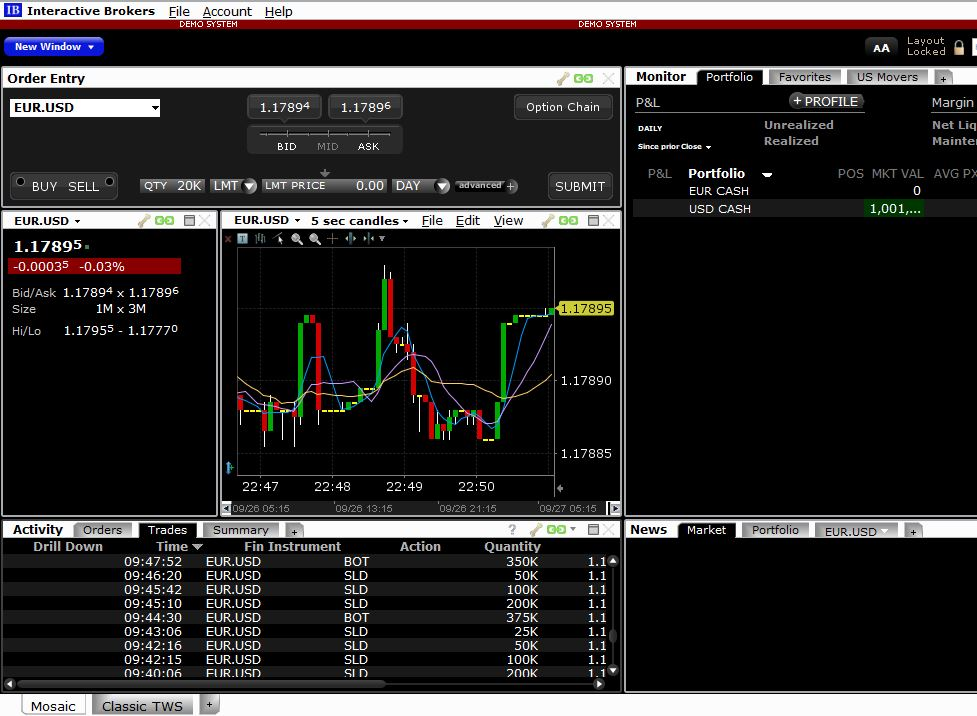

In [ ]:
ma_trader.exit()

声明：本资料仅供内部学习使用，切勿外传。